RetrievedModernaVaccine
RetrievedJohnsonAndJohnsonVaccine
RetrievedPfizerVaccine


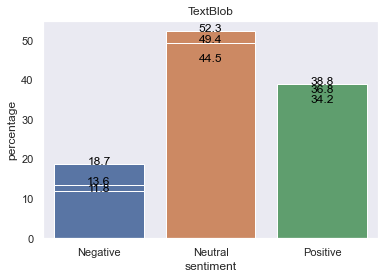

In [7]:
import twitter, datetime
import json
import pymongo
from dotenv import load_dotenv 
import os 
import pandas
import preprocessor as p
import numpy as np
from textblob import TextBlob
import seaborn as sns

load_dotenv()                  

mongo = os.environ.get('mongo')
db = os.environ.get('db')

def oauth_login():
    '''
    A static method to authenticate user
    It uses OAuth2.0 specification which takes a bearer token to authenticate user
    '''

    CONSUMER_KEY = os.environ.get('CONSUMER_KEY')
    CONSUMER_SECRET = os.environ.get('CONSUMER_SECRET')
    BEARER_TOKEN= os.environ.get('BEARER_TOKEN')
    
    auth = twitter.OAuth2(CONSUMER_KEY, CONSUMER_SECRET, BEARER_TOKEN)
    api = twitter.Twitter(auth=auth)
    return api

def make_twitter_request(api_func, max_errors=10, *args, **kw): 
    '''
    A nested helper function that handles common HTTPErrors. Return an updated
    value for wait_period if the problem is a 500 level error. Block until the
    rate limit is reset if it's a rate limiting issue (429 error). Returns None
    for 401 and 404 errors, which requires special handling by the caller.
    '''

    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        '''
        This helper function handles run-time error such as 429, it sleeps until the timeout
        This method is referred from Twitter Cookbook
        '''
    
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e    
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429: 
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e 
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered {0} Error. Retrying in {1} seconds'.format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

def twitter_search(twitter_api, q, max_results=200, **kw):

    # See https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets
    # and https://developer.twitter.com/en/docs/tweets/search/guides/standard-operators
    # for details on advanced search criteria that may be useful for 
    # keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=100, **kw)
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://developer.twitter.com/en/docs/basics/rate-limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

def clean_results(result, topic):
    '''
    To take required text for NLP, may change later as per the requirement
    '''
    final = []
    for arr in result["statuses"]:
        obj = dict()
        obj["tweet"] = arr["text"]
        obj["id"] = arr["id_str"]
        obj["name"] = arr["user"]["name"]
        obj["location"] = arr["user"]["location"]
        obj["topic"] = topic
        obj["created_at"] = arr["created_at"]
        obj["processed_on"] = datetime.datetime.now().isoformat(' ', 'seconds')
        final.append(obj)
    return final


def save_tweets(tweets, topic):
    '''
    This method will help us on saving tweets
    '''
    client = pymongo.MongoClient(mongo)
    database = client[db]
    coll = database[topic]
    try:
        result = coll.insert_many(tweets)
        print("done inserting")
        return result
    except Exception as e:
        print(e)

def query_tweet(query, count, topic):
    '''
    Queries and finds tweet for different hashtags/topic, it will keep on searching until it finds total count
    '''
    api = oauth_login()
    result = api.search.tweets(q=query, count=500)
    print(result["search_metadata"])
    save_tweets(clean_results(result, topic), topic)
    result_count = result["search_metadata"]["count"]
    next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
    while result_count < count:
        result = api.search.tweets(q=query, include_entities='true',max_id=next_max_id, count=500 )
        print(result["search_metadata"])
        print(result_count)
        save_tweets(clean_results(result, topic), topic)
        result_count += result["search_metadata"]["count"]
        if "next_results" in result["search_metadata"]:
            next_max_id = result["search_metadata"]["next_results"].split('max_id=')[1].split('&')[0]
        else:
            break
        
def get_docs(col):
    client = pymongo.MongoClient(mongo)
    database = client[db]
    coll = database[col]    
    try:
        result = coll.find()
        arr = []
        for r in result:
            arr.append(r)
        print("Retrieved" + col)
        return arr
    except Exception as e:
        print(e)

def remove_punctuations(text):
    punct =['%','/',':','\\','&amp;','&',';']
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text


# Define function to get value counts
def get_value_counts(col_name, analyzer_name, tweets_df):
    count = pandas.DataFrame(tweets_df[col_name].value_counts())
    percentage = pandas.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pandas.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

def main():
    try:
        
        topics = ["ModernaVaccine","JohnsonAndJohnsonVaccine", "PfizerVaccine"]
        # topics = ["vaccinated"]
        # topics = ["ModernaVaccine"]
        final = []
        for topic in topics:
            # query_tweet("#"+ topic+" -RT AND lang:en", 10000, topic)
            # print(json.dumps(result, indent=1))
            # print("Done writing"+topic)           
            result_from_db = get_docs(topic)
            result = pandas.DataFrame(result_from_db)
            result.sort_values(by="created_at")
            # print(result.head(n=5))
            result_copy = result.copy()
            result_copy['tweet_cleaned'] = result_copy['tweet'].apply(lambda x: p.clean(x))
            # print(result.head(n=5))
            # print(result_copy.head(n=5))
            # print(len(result_copy))
            result_copy.drop_duplicates(subset='tweet_cleaned', keep='first', inplace=True)
            # print(len(result_copy))

            # remove punctuations
            result_copy['tweet_cleaned'] = result_copy['tweet_cleaned'].apply(lambda x: remove_punctuations(x))

            
            # Drop tweets which have empty text field
            result_copy['tweet_cleaned'].replace('', np.nan, inplace=True)
            result_copy['tweet_cleaned'].replace(' ', np.nan, inplace=True)
            result_copy.dropna(subset=['tweet_cleaned'], inplace=True)
            # print(len(result_copy))
            # print(result_copy.head(n=5))

            result_copy = result_copy.reset_index(drop=True)
            # print(result_copy.sample(5))


            #sentiment analysis
            # Obtain polarity scores generated by TextBlob
            result_copy['textblob_score'] = result_copy['tweet_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
            # neutral_thresh = 0.05

            # Convert polarity score into sentiment categories
            result_copy['textblob_sentiment'] = result_copy['textblob_score'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -(0.05) else 'Neutral'))
            # print(result_copy['textblob_sentiment'].describe())
            
            textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob', result_copy)
            # print(textblob_sentiment_df)
            
            final.append(textblob_sentiment_df)

            sns.set_theme(style="dark")
            ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
            ax.set_title('TextBlob')

            for index, row in textblob_sentiment_df.iterrows():
                ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

        # print(final)


    except Exception as e:
        print(e)

if __name__ == '__main__':
    main()
    